# A320-232
## https://eurocontrol-bada.github.io/pybada/API_reference/aircraft.html#pyBADA.aircraft.Airplane

In [1]:
from pyBADA.bada4 import Bada4Aircraft

AC = Bada4Aircraft(
    badaVersion="4.2",
    acName="A320-232",
    filePath="/home/longqin/Downloads/4.2/BADA_4.2_L06514UPC/Models",
)

print("Aircraft loaded successfully!")
print(f"Aircraft type: {AC.acName}")
print(f"BADA version: {AC.BADAVersion}")
print(f"BADA family: {AC.BADAFamily}")
print(f"BADA family name: {AC.BADAFamilyName}")

Aircraft loaded successfully!
Aircraft type: A320-232
BADA version: 4.2
BADA family: <pyBADA.aircraft.BadaFamily object at 0x745d483cf800>
BADA family name: BADA4


In [10]:
#1. 获取飞机基本参数
print(f"最大起飞重量 (MTOW): {AC.MTOW} kg")
print(f"参考面积: {AC.S} m²")

最大起飞重量 (MTOW): 78000.0 kg
参考面积: 122.6 m²


In [34]:
from pyBADA.bada4 import Bada4Aircraft, ARPM
import pyBADA.atmosphere as atm

# 1. 已有的Aircraft对象
AC = Bada4Aircraft(
    badaVersion="4.2",
    acName="A320-232",
    filePath="/home/longqin/Downloads/4.2/BADA_4.2_L06514UPC/Models",
)

# 2. 创建ARPM实例
arpm = ARPM(AC)

# 3. 设置参数 - 使用英尺作为高度单位，然后转换为米
altitude_feet = 1000 # 高度，单位英尺
altitude_meters = altitude_feet * 0.3048  # 转换为米
mass = 60000      # 飞机质量，单位千克
runway_elevation_feet = 0  # 跑道海拔高度，单位英尺
runway_elevation_meters = runway_elevation_feet * 0.3048  # 转换为米

# 4. 计算给定高度的大气参数
DeltaTemp = 0.0  # 与ISA温度的偏差
theta_val = atm.theta(altitude_meters, DeltaTemp)
delta_val = atm.delta(altitude_meters, DeltaTemp)

# 5. 调用descentSpeed方法
descent_cas, status = arpm.descentSpeed(
    theta=theta_val,
    delta=delta_val,
    mass=mass,
    h=altitude_meters,
    hRWY=runway_elevation_meters,
    speedSchedule_default=None,
    config=None,
    DeltaTemp=0.0
)

# 6. 输出结果
print(f"高度: {altitude_feet} 英尺 ({altitude_meters:.1f} 米)")
print(f"下降校准空速(CAS): {descent_cas:.2f} m/s")
print(f"状态标志: {status}")
print(f"下降校准空速: {descent_cas * 1.94384:.1f} 节")


高度: 1000 英尺 (304.8 米)
下降校准空速(CAS): 71.27 m/s
状态标志: 
下降校准空速: 138.5 节


In [40]:
from pyBADA.bada4 import Bada4Aircraft, BADA4
import pyBADA.atmosphere as atm

# 尝试不同的导入方式找到conv模块
try:
    # 可能的导入路径1
    from pyBADA import conversion as conv
    print("成功导入 pyBADA.conversion")
except ImportError:
    try:
        # 可能的导入路径2
        from pyBADA import conv
        print("成功导入 pyBADA.conv")
    except ImportError:
        # 找不到模块，创建自己的转换函数
        print("找不到转换模块，使用自定义转换函数")
        class conv:
            @staticmethod
            def ft2m(feet):
                return feet * 0.3048
            
            @staticmethod
            def m2ft(meters):
                return meters / 0.3048
            
            @staticmethod
            def kt2ms(knots):
                return knots * 0.51444
            
            @staticmethod
            def ms2kt(ms):
                return ms / 0.51444

# 初始化A320-232飞机模型
AC = Bada4Aircraft(
    badaVersion="4.2",
    acName="A320-232",
    filePath="/home/longqin/Downloads/4.2/BADA_4.2_L06514UPC/Models",
)

# 创建BADA4性能计算对象
bada4 = BADA4(AC)

# 设置飞行条件
altitude_ft = 30000           # 高度(英尺)
altitude = conv.ft2m(altitude_ft)  # 转换为米
mass = 60000                  # 飞机质量(kg)
mach = 0.78                   # 马赫数
DeltaTemp = 0                 # 温度偏差(K)

# 计算大气参数
theta_val = atm.theta(altitude, DeltaTemp)
delta_val = atm.delta(altitude, DeltaTemp)
sigma_val = atm.sigma(theta_val, delta_val)

# 1. 计算升力系数
cl = bada4.CL(delta=delta_val, mass=mass, M=mach)
print(f"升力系数(CL): {cl:.4f}")

# 2. 计算阻力系数 - 假设干净构型(无襟翼，起落架收起)
HLid = 0.0  # 干净构型(无襟翼)
LG = "LGUP"  # 起落架收起
cd = bada4.CD(HLid=HLid, LG=LG, CL=cl, M=mach)
print(f"阻力系数(CD): {cd:.4f}")

# 3. 计算实际升力和阻力
lift = bada4.L(delta=delta_val, M=mach, CL=cl)
drag = bada4.D(delta=delta_val, M=mach, CD=cd)
print(f"升力: {lift:.1f} N")
print(f"阻力: {drag:.1f} N")

# 4. 计算最大推力(爬升设置)
max_thrust = bada4.Thrust(
    delta=delta_val,
    theta=theta_val,
    M=mach,
    rating="MCMB",  # 最大爬升设置
    DeltaTemp=DeltaTemp
)
print(f"最大爬升推力: {max_thrust:.1f} N")

# 5. 计算巡航推力(巡航设置)
cruise_thrust = bada4.Thrust(
    delta=delta_val,
    theta=theta_val,
    M=mach,
    rating="MCRZ",  # 巡航设置
    DeltaTemp=DeltaTemp
)
print(f"巡航推力: {cruise_thrust:.1f} N")

# 6. 计算怠速推力
idle_thrust = bada4.Thrust(
    delta=delta_val,
    theta=theta_val,
    M=mach,
    rating="LIDL",  # 怠速设置
    DeltaTemp=DeltaTemp
)
print(f"怠速推力: {idle_thrust:.1f} N")

# 7. 计算真空速
tas = atm.mach2Tas(mach, theta_val)
print(f"真空速: {tas:.1f} m/s ({conv.ms2kt(tas):.1f} 节)")

# 8. 计算燃油流量(巡航状态)
fuel_flow = bada4.ff(
    delta=delta_val,
    theta=theta_val,
    M=mach,
    rating="MCRZ",
    DeltaTemp=DeltaTemp
)
print(f"巡航燃油流量: {fuel_flow:.4f} kg/s")
print(f"小时油耗: {fuel_flow * 3600:.1f} kg/h")

找不到转换模块，使用自定义转换函数
升力系数(CL): 0.3745
阻力系数(CD): 0.0254
升力: 588399.0 N
阻力: 39927.7 N
最大爬升推力: 56914.1 N
巡航推力: 51168.4 N
怠速推力: -1851.0 N
真空速: 236.5 m/s (459.7 节)
巡航燃油流量: 0.8830 kg/s
小时油耗: 3178.7 kg/h


## A320-232 下降性能   Flight Path Angle

In [42]:
from pyBADA.bada4 import Bada4Aircraft, BADA4
import pyBADA.atmosphere as atm
import math

# 自定义转换函数
class conv:
    @staticmethod
    def ft2m(feet):
        return feet * 0.3048
    
    @staticmethod
    def m2ft(meters):
        return meters / 0.3048
    
    @staticmethod
    def kt2ms(knots):
        return knots * 0.51444
    
    @staticmethod
    def ms2kt(ms):
        return ms / 0.51444

# 初始化A320-232飞机模型
AC = Bada4Aircraft(
    badaVersion="4.2",
    acName="A320-232",
    filePath="/home/longqin/Downloads/4.2/BADA_4.2_L06514UPC/Models",
)

# 创建BADA4性能计算对象
bada4 = BADA4(AC)

# 计算不同高度的下降性能
def calculate_descent_performance(altitude_ft, mass_kg, mach=None, cas_kt=None, DeltaTemp=0):
    """计算特定高度、重量和速度下的下降性能"""
    altitude = conv.ft2m(altitude_ft)
    
    # 计算大气参数
    theta_val = atm.theta(altitude, DeltaTemp)
    delta_val = atm.delta(altitude, DeltaTemp)
    sigma_val = atm.sigma(theta_val, delta_val)
    
    # 确定速度 - 优先使用马赫数，否则使用CAS
    if mach is not None:
        M = mach
        tas = atm.mach2Tas(M, theta_val)
        cas = atm.mach2Cas(M, theta_val, delta_val, sigma_val)
    elif cas_kt is not None:
        cas = conv.kt2ms(cas_kt)
        tas = atm.cas2Tas(cas, delta_val, sigma_val)
        M = atm.tas2Mach(tas, theta_val)
    else:
        raise ValueError("必须提供马赫数或校准空速")
    
    # 计算升力系数
    cl = bada4.CL(delta=delta_val, mass=mass_kg, M=M)
    
    # 计算阻力系数(干净构型)
    HLid = 0.0  # 无襟翼
    LG = "LGUP"  # 起落架收起
    cd = bada4.CD(HLid=HLid, LG=LG, CL=cl, M=M)
    
    # 计算阻力
    drag = bada4.D(delta=delta_val, M=M, CD=cd)
    
    # 计算怠速推力
    idle_thrust = bada4.Thrust(
        delta=delta_val,
        theta=theta_val,
        M=M,
        rating="LIDL",  # 怠速设置
        DeltaTemp=DeltaTemp
    )
    
    # 能量分配因子(下降)
    esf_des = 1.0  # 典型值
    
    # 计算怠速下降率
    idle_descent_rate = bada4.ROCD(
        T=idle_thrust,
        D=drag,
        v=tas,
        mass=mass_kg,
        ESF=esf_des,
        h=altitude,
        DeltaTemp=DeltaTemp
    )
    
    # 计算下降角(度)
    if tas > 0:
        descent_angle = math.degrees(math.asin(idle_descent_rate / tas))
    else:
        descent_angle = 0
    
    # 计算下降梯度(百分比)
    descent_gradient = 100 * abs(idle_descent_rate / tas) if tas > 0 else 0
    
    # 返回结果
    return {
        "高度": f"{altitude_ft} 英尺 ({altitude:.1f} 米)",
        "马赫数": f"{M:.3f}",
        "校准空速": f"{conv.ms2kt(cas):.1f} 节",
        "真空速": f"{tas:.1f} m/s ({conv.ms2kt(tas):.1f} 节)",
        "下降率": f"{idle_descent_rate:.2f} m/s ({idle_descent_rate * 196.85:.0f} ft/min)",
        "下降角": f"{descent_angle:.2f} 度",
        "下降梯度": f"{descent_gradient:.2f}%",
        "阻力": f"{drag:.1f} N",
        "怠速推力": f"{idle_thrust:.1f} N"
    }

# 计算不同高度的下降性能
altitudes = [10000, 20000, 30000, 40000]
mass = 60000  # 60吨

print("A320-232 下降性能 - 使用马赫数0.78:")
print("=" * 80)
for alt in altitudes:
    result = calculate_descent_performance(alt, mass, mach=0.78)
    print(f"\n高度: {result['高度']}")
    print(f"马赫数: {result['马赫数']}")
    print(f"校准空速: {result['校准空速']}")
    print(f"真空速: {result['真空速']}")
    print(f"下降率: {result['下降率']}")
    print(f"下降角: {result['下降角']}")
    print(f"下降梯度: {result['下降梯度']}")
    print(f"阻力: {result['阻力']}")
    print(f"怠速推力: {result['怠速推力']}")
    print("-" * 60)

print("\nA320-232 下降性能 - 使用校准空速250节:")
print("=" * 80)
for alt in altitudes:
    result = calculate_descent_performance(alt, mass, cas_kt=250)
    print(f"\n高度: {result['高度']}")
    print(f"马赫数: {result['马赫数']}")
    print(f"校准空速: {result['校准空速']}")
    print(f"真空速: {result['真空速']}")
    print(f"下降率: {result['下降率']}")
    print(f"下降角: {result['下降角']}")
    print(f"下降梯度: {result['下降梯度']}")
    print(f"阻力: {result['阻力']}")
    print(f"怠速推力: {result['怠速推力']}")
    print("-" * 60)

A320-232 下降性能 - 使用马赫数0.78:

高度: 10000 英尺 (3048.0 米)
马赫数: 0.780
校准空速: 510.9 节
真空速: 256.1 m/s (497.9 节)
下降率: -49.19 m/s (-9683 ft/min)
下降角: -11.07 度
下降梯度: 19.20%
阻力: 82633.5 N
怠速推力: -30368.4 N
------------------------------------------------------------

高度: 20000 英尺 (6096.0 米)
马赫数: 0.780
校准空速: 510.8 节
真空速: 246.5 m/s (479.2 节)
下降率: -28.83 m/s (-5674 ft/min)
下降角: -6.72 度
下降梯度: 11.69%
阻力: 56893.5 N
怠速推力: -11911.4 N
------------------------------------------------------------

高度: 30000 英尺 (9144.0 米)
马赫数: 0.780
校准空速: 517.4 节
真空速: 236.5 m/s (459.7 节)
下降率: -16.79 m/s (-3305 ft/min)
下降角: -4.07 度
下降梯度: 7.10%
阻力: 39927.7 N
怠速推力: -1851.0 N
------------------------------------------------------------

高度: 40000 英尺 (12192.0 米)
马赫数: 0.780
校准空速: 548.3 节
真空速: 230.2 m/s (447.4 节)
下降率: -12.64 m/s (-2488 ft/min)
下降角: -3.15 度
下降梯度: 5.49%
阻力: 35040.0 N
怠速推力: 2733.3 N
------------------------------------------------------------

A320-232 下降性能 - 使用校准空速250节:

高度: 10000 英尺 (3048.0 米)
马赫数: 0.389
校准空速: 250.0 节
真

## A320-232 Crossover高度计算
==================================================
马赫数: 0.78
校准空速: 300 节 (154.33 m/s)
过渡高度: 8935.1 米
过渡高度: 29315 英尺

不同马赫数/CAS组合的过渡高度:
==================================================
马赫 0.78 / 280 节 CAS: 32465 英尺 英尺
马赫 0.78 / 300 节 CAS: 29315 英尺 英尺
马赫 0.8 / 300 节 CAS: 30595 英尺 英尺
马赫 0.76 / 300 节 CAS: 27994 英尺 英尺
马赫 0.78 / 320 节 CAS: 26269 英尺 英尺

In [43]:
import pyBADA.atmosphere as atm

# 自定义转换函数
class conv:
    @staticmethod
    def ft2m(feet):
        return feet * 0.3048
    
    @staticmethod
    def m2ft(meters):
        return meters / 0.3048
    
    @staticmethod
    def kt2ms(knots):
        return knots * 0.51444
    
    @staticmethod
    def ms2kt(ms):
        return ms / 0.51444

def calculate_crossover_altitude(mach, cas_kt):
    """计算马赫数和校准空速的过渡高度"""
    # 将校准空速从节转换为米/秒
    cas_ms = conv.kt2ms(cas_kt)
    
    # 计算过渡高度(米)
    crossover_altitude_m = atm.crossOver(cas=cas_ms, Mach=mach)
    
    # 转换为英尺
    crossover_altitude_ft = conv.m2ft(crossover_altitude_m)
    
    return {
        "马赫数": mach,
        "校准空速": f"{cas_kt} 节 ({cas_ms:.2f} m/s)",
        "过渡高度(米)": f"{crossover_altitude_m:.1f} 米",
        "过渡高度(英尺)": f"{crossover_altitude_ft:.0f} 英尺"
    }

# 计算A320-232典型的过渡高度
result = calculate_crossover_altitude(0.78, 300)

print("A320-232 Crossover高度计算")
print("=" * 50)
print(f"马赫数: {result['马赫数']}")
print(f"校准空速: {result['校准空速']}")
print(f"过渡高度: {result['过渡高度(米)']}")
print(f"过渡高度: {result['过渡高度(英尺)']}")

# 计算多组马赫数/CAS组合的过渡高度
print("\n不同马赫数/CAS组合的过渡高度:")
print("=" * 50)
combinations = [
    (0.78, 280),  # 典型A320下降剖面
    (0.78, 300),  # 您请求的组合
    (0.80, 300),  # 更高马赫数
    (0.76, 300),  # 更低马赫数
    (0.78, 320)   # 更高CAS
]

for mach, cas in combinations:
    result = calculate_crossover_altitude(mach, cas)
    print(f"马赫 {mach} / {cas} 节 CAS: {result['过渡高度(英尺)']} 英尺")

A320-232 Crossover高度计算
马赫数: 0.78
校准空速: 300 节 (154.33 m/s)
过渡高度: 8935.1 米
过渡高度: 29315 英尺

不同马赫数/CAS组合的过渡高度:
马赫 0.78 / 280 节 CAS: 32465 英尺 英尺
马赫 0.78 / 300 节 CAS: 29315 英尺 英尺
马赫 0.8 / 300 节 CAS: 30595 英尺 英尺
马赫 0.76 / 300 节 CAS: 27994 英尺 英尺
马赫 0.78 / 320 节 CAS: 26269 英尺 英尺


## A320-232最优巡航高度和速度计算

In [ ]:
from pyBADA.bada4 import Bada4Aircraft, BADA4
import pyBADA.atmosphere as atm
import numpy as np

# 自定义转换函数
class conv:
    @staticmethod
    def ft2m(feet):
        return feet * 0.3048
    
    @staticmethod
    def m2ft(meters):
        return meters / 0.3048
    
    @staticmethod
    def kt2ms(knots):
        return knots * 0.51444
    
    @staticmethod
    def ms2kt(ms):
        return ms / 0.51444

# 初始化A320-232飞机模型
AC = Bada4Aircraft(
    badaVersion="4.2",
    acName="A320-232",
    filePath="/home/longqin/Downloads/4.2/BADA_4.2_L06514UPC/Models",
)

# 创建BADA4性能计算对象
bada4 = BADA4(AC)

# A320-232最大着陆重量
max_landing_weight = 64500  # kg

# 计算不同百分比的最大着陆重量
weights = {
    "90%": int(max_landing_weight * 1.2),
    "85%": int(max_landing_weight * 0.85),
    "80%": int(max_landing_weight * 0.80)
}

def calculate_specific_range(altitude_ft, mach, mass, DeltaTemp=0):
    """计算特定高度、速度和重量下的单位燃油航程(Specific Range)"""
    altitude = conv.ft2m(altitude_ft)
    
    # 计算大气参数
    theta_val = atm.theta(altitude, DeltaTemp)
    delta_val = atm.delta(altitude, DeltaTemp)
    sigma_val = atm.sigma(theta_val, delta_val)
    
    # 计算真空速
    tas = atm.mach2Tas(mach, theta_val)
    
    # 计算升力系数
    cl = bada4.CL(delta=delta_val, mass=mass, M=mach)
    
    # 计算阻力系数(干净构型)
    HLid = 0.0  # 无襟翼
    LG = "LGUP"  # 起落架收起
    cd = bada4.CD(HLid=HLid, LG=LG, CL=cl, M=mach)
    
    # 计算阻力
    drag = bada4.D(delta=delta_val, M=mach, CD=cd)
    
    # 计算巡航推力
    cruise_thrust = bada4.Thrust(
        delta=delta_val,
        theta=theta_val,
        M=mach,
        rating="MCRZ",  # 巡航设置
        DeltaTemp=DeltaTemp
    )
    
    # 确保推力足够克服阻力
    if cruise_thrust < drag:
        return 0  # 推力不足，不可行的飞行条件A320-232 Crossover高度计算
    
    # 计算燃油流量
    fuel_flow = bada4.ff(
        delta=delta_val,
        theta=theta_val,
        M=mach,
        rating="MCRZ",
        DeltaTemp=DeltaTemp
    )
    
    if fuel_flow <= 0:
        return 0  # 避免除以零
    
    # 计算单位燃油航程(nm/kg)
    specific_range = (tas / fuel_flow) * 0.000539957  # 转换为海里/kg
    
    return specific_range

def find_optimal_cruise(mass):
    """寻找给定重量下的最优巡航高度和速度"""
    # 定义搜索范围
    altitudes = range(28000, 41000, 1000)  # 从28000到40000英尺，步长1000英尺
    mach_numbers = np.arange(0.74, 0.81, 0.01)  # 从0.74到0.80马赫，步长0.01
    
    best_sr = 0
    optimal_alt = 0
    optimal_mach = 0
    
    # 遍历所有高度和速度组合
    for alt in altitudes:
        for mach in mach_numbers:
            sr = calculate_specific_range(alt, mach, mass)
            if sr > best_sr:
                best_sr = sr
                optimal_alt = alt
                optimal_mach = mach
    
    # 计算对应的校准空速
    altitude = conv.ft2m(optimal_alt)
    theta_val = atm.theta(altitude, 0)
    delta_val = atm.delta(altitude, 0)
    sigma_val = atm.sigma(theta_val, delta_val)
    tas = atm.mach2Tas(optimal_mach, theta_val)
    cas = atm.mach2Cas(optimal_mach, theta_val, delta_val, sigma_val)
    
    return {
        "重量": f"{mass} kg",
        "最优高度": f"{optimal_alt} 英尺",
        "最优马赫数": f"{optimal_mach:.3f}",
        "对应校准空速": f"{conv.ms2kt(cas):.1f} 节",
        "对应真空速": f"{conv.ms2kt(tas):.1f} 节",
        "单位燃油航程": f"{best_sr:.4f} nm/kg ({best_sr * 1000:.2f} nm/ton)"
    }

# 计算并显示各重量的最优巡航参数
print("A320-232 在不同重量下的最优巡航参数:")
print("=" * 70)

for weight_percent, weight_kg in weights.items():
    print(f"\n最大着陆重量的 {weight_percent} ({weight_kg} kg):")
    result = find_optimal_cruise(weight_kg)
    print(f"  最优巡航高度: {result['最优高度']}")
    print(f"  最优巡航马赫数: {result['最优马赫数']}")
    print(f"  对应校准空速: {result['对应校准空速']}")
    print(f"  对应真空速: {result['对应真空速']}")
    print(f"  单位燃油航程: {result['单位燃油航程']}")
    print("-" * 60)

A320-232 在不同重量下的最优巡航参数:

最大着陆重量的 90% (77400 kg):
  最优巡航高度: 34000 英尺
  最优巡航马赫数: 0.780
  对应校准空速: 523.0 节
  对应真空速: 451.6 节
  单位燃油航程: 0.1617 nm/kg (161.73 nm/ton)
------------------------------------------------------------

最大着陆重量的 85% (54825 kg):
  最优巡航高度: 40000 英尺
  最优巡航马赫数: 0.790
  对应校准空速: 557.5 节
  对应真空速: 453.1 节
  单位燃油航程: 0.2039 nm/kg (203.86 nm/ton)
------------------------------------------------------------

最大着陆重量的 80% (51600 kg):
  最优巡航高度: 40000 英尺
  最优巡航马赫数: 0.790
  对应校准空速: 557.5 节
  对应真空速: 453.1 节
  单位燃油航程: 0.2039 nm/kg (203.86 nm/ton)
------------------------------------------------------------


In [ ]:
from pyBADA.bada4 import Bada4Aircraft, BADA4
import pyBADA.atmosphere as atm
import math
import pandas as pd

# 自定义转换函数
class conv:
    @staticmethod
    def ft2m(feet):
        return feet * 0.3048
    
    @staticmethod
    def m2ft(meters):
        return meters / 0.3048
   
    @staticmethod
    def kt2ms(knots):
        return knots * 0.51444
    
    @staticmethod
    def ms2kt(ms):
        return ms / 0.51444

# 初始化A320-232飞机模型
AC = Bada4Aircraft(
    badaVersion="4.2",
    acName="A320-232",
    filePath="/home/longqin/Downloads/4.2/BADA_4.2_L06514UPC/Models",
)

# 创建BADA4性能计算对象
bada4 = BADA4(AC)

# 设置A320参数
max_landing_weight = 64500  # kg
aircraft_mass = int(max_landing_weight * 0.90)  # 90%最大着陆重量
print(f"飞机重量: {aircraft_mass} kg (MLW的90%)")

# 计算马赫0.78和300节CAS的过渡高度
def calculate_crossover_altitude(mach, cas_kt):
    cas_ms = conv.kt2ms(cas_kt)
    crossover_altitude_m = atm.crossOver(cas=cas_ms, Mach=mach)
    crossover_altitude_ft = conv.m2ft(crossover_altitude_m)
    crossover_fl = int(crossover_altitude_ft / 100)
    return crossover_altitude_m, crossover_altitude_ft, crossover_fl

crossover_m, crossover_ft, crossover_fl = calculate_crossover_altitude(0.78, 300)
print(f"过渡高度: FL{crossover_fl} ({int(crossover_ft)} 英尺)")

def calculate_descent_performance(flight_level, aircraft_mass, DeltaTemp=0):
    """计算指定飞行高度层的下降性能"""
    altitude_ft = flight_level * 100
    altitude_m = conv.ft2m(altitude_ft)
    
    # 计算大气参数
    # theta_val = atm.theta(altitude_m, DeltaTemp)
    # delta_val = atm.delta(altitude_m, DeltaTemp)
    # sigma_val = atm.sigma(theta_val, delta_val)

    theta_val, delta_val, sigma_val = atm.atmosphereProperties(altitude_m, DeltaTemp)
    
    # 根据下降速度规则确定速度
    if flight_level >= crossover_fl:
        # 使用马赫数0.78
        M = 0.73
        tas = atm.mach2Tas(M, theta_val)
        cas = atm.mach2Cas(M, theta_val, delta_val, sigma_val)
        speed_mode = "Mach"
    elif flight_level >= 100:
        # 使用300节CAS
        cas = conv.kt2ms(280)
        tas = atm.cas2Tas(cas, delta_val, sigma_val)
        M = atm.tas2Mach(tas, theta_val)
        speed_mode = "CAS 300kt"
    else:
        # 使用250节CAS
        cas = conv.kt2ms(250)
        tas = atm.cas2Tas(cas, delta_val, sigma_val)
        M = atm.tas2Mach(tas, theta_val)
        speed_mode = "CAS 250kt"
    
    # 计算升力系数
    cl = bada4.CL(delta=delta_val, mass=aircraft_mass, M=M)
    
    # 计算阻力系数(干净构型)
    HLid = 0.0  # 无襟翼
    LG = "LGUP"  # 起落架收起
    cd = bada4.CD(HLid=HLid, LG=LG, CL=cl, M=M)
    
    # 计算阻力
    drag = bada4.D(delta=delta_val, M=M, CD=cd)
    
    # 计算怠速推力
    idle_thrust = bada4.Thrust(
        delta=delta_val,
        theta=theta_val,
        M=M,
        rating="LIDL",  # 怠速设置
        DeltaTemp=DeltaTemp
    )
    
    # 能量分配因子(下降)
    esf_des = 1# 典型值
    
    # 计算怠速下降率
    idle_descent_rate = bada4.ROCD(
        T=idle_thrust,
        D=drag,
        v=tas,
        mass=aircraft_mass,
        ESF=esf_des,
        h=altitude_m,
        DeltaTemp=DeltaTemp
    )
    
    # 计算下降角(度)
    if tas > 0:
        descent_angle = math.degrees(math.asin(idle_descent_rate / tas))
    else:
        descent_angle = 0
    
    # 计算下降梯度(百分比)
    descent_gradient = 100 * abs(idle_descent_rate / tas) if tas > 0 else 0

    ft_per_nm = abs(idle_descent_rate * 196.85 / conv.ms2kt(tas) * 60) if conv.ms2kt(tas) > 0 else 0

    
    return {
        "FL": flight_level,
        "高度(ft)": altitude_ft,
        "速度模式": speed_mode,
        "马赫数": M,
        "CAS(kt)": conv.ms2kt(cas),
        "TAS(kt)": conv.ms2kt(tas),
        "下降率(ft/min)": idle_descent_rate * 196.85,
        "下降率(m/s)": idle_descent_rate,
        "下降角(度)": descent_angle,
        "下降梯度(%)": descent_gradient,
        "高距离(ft/nm)": ft_per_nm, 
        "阻力(N)": drag,
        "怠速推力(N)": idle_thrust
    }

# 计算不同飞行高度层的下降性能
flight_levels = [350, 320, 300, 280, 260, 240, 220, 200, 180, 160, 140, 120, 100, 80, 60, 40, 20]
results = []

for fl in flight_levels:
    result = calculate_descent_performance(fl, aircraft_mass)
    results.append(result)

# 创建DataFrame展示结果
df = pd.DataFrame(results)

# 打印结果
print("\nA320-232 下降剖面 (.78M/300/250下降法则):")
print("=" * 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format
print(df[['FL', '速度模式', 'CAS(kt)', 'TAS(kt)', '下降率(ft/min)', '下降角(度)', '下降梯度(%)', '高距离(ft/nm)']])

飞机重量: 58050 kg (MLW的90%)
过渡高度: FL293 (29314 英尺)

A320-232 下降剖面 (.78M/300/250下降法则):
     FL       速度模式  CAS(kt)  TAS(kt)  下降率(ft/min)  下降角(度)  下降梯度(%)  高距离(ft/nm)
0   350       Mach   245.88   420.79      -692.90   -0.93     1.63       98.80
1   320       Mach   263.16   426.47      -768.65   -1.02     1.78      108.14
2   300       Mach   275.03   430.21      -836.79   -1.10     1.92      116.70
3   280  CAS 300kt   280.00   423.85      -859.39   -1.15     2.00      121.65
4   260  CAS 300kt   280.00   410.83      -842.00   -1.16     2.02      122.97
5   240  CAS 300kt   280.00   398.29      -822.60   -1.17     2.04      123.92
6   220  CAS 300kt   280.00   386.21      -801.29   -1.17     2.05      124.48
7   200  CAS 300kt   280.00   374.59      -778.20   -1.18     2.05      124.65
8   180  CAS 300kt   280.00   363.41      -753.66   -1.17     2.05      124.43
9   160  CAS 300kt   280.00   352.65      -728.16   -1.17     2.04      123.89
10  140  CAS 300kt   280.00   342.30      -702.3

In [80]:
from pyBADA.bada4 import Bada4Aircraft, BADA4
import pyBADA.atmosphere as atm
import math
import pandas as pd
from pyBADA.aircraft import Airplane 

# 自定义转换函数
class conv:
    @staticmethod
    def ft2m(feet):
        return feet * 0.3048
    
    @staticmethod
    def m2ft(meters):
        return meters / 0.3048
   
    @staticmethod
    def kt2ms(knots):
        return knots * 0.51444
    
    @staticmethod
    def ms2kt(ms):
        return ms / 0.51444

# 初始化A320-232飞机模型
AC = Bada4Aircraft(
    badaVersion="4.2",
    acName="A320-232",
    filePath="/home/longqin/Downloads/4.2/BADA_4.2_L06514UPC/Models",
)

# 创建BADA4性能计算对象
bada4 = BADA4(AC)

# 设置A320参数
max_landing_weight = 64500  # kg
aircraft_mass = int(max_landing_weight * 0.90)  # 90%最大着陆重量
print(f"飞机重量: {aircraft_mass} kg (MLW的90%)")

# 计算马赫0.78和300节CAS的过渡高度
def calculate_crossover_altitude(mach, cas_kt):
    cas_ms = conv.kt2ms(cas_kt)
    crossover_altitude_m = atm.crossOver(cas=cas_ms, Mach=mach)
    crossover_altitude_ft = conv.m2ft(crossover_altitude_m)
    crossover_fl = int(crossover_altitude_ft / 100)
    return crossover_altitude_m, crossover_altitude_ft, crossover_fl

crossover_m, crossover_ft, crossover_fl = calculate_crossover_altitude(0.78, 300)
print(f"过渡高度: FL{crossover_fl} ({int(crossover_ft)} 英尺)")

def calculate_descent_performance(flight_level, aircraft_mass, DeltaTemp=0):
    """计算指定飞行高度层的下降性能"""
    altitude_ft = flight_level * 100
    altitude_m = conv.ft2m(altitude_ft)
    
    # 计算大气参数
    theta_val, delta_val, sigma_val = atm.atmosphereProperties(altitude_m, DeltaTemp)
    
    # 根据下降速度规则确定速度
    if flight_level >= crossover_fl:
        # 使用马赫数0.73
        M = 0.78
        tas = atm.mach2Tas(M, theta_val)
        cas = atm.mach2Cas(M, theta_val, delta_val, sigma_val)
        speed_mode = "Mach"
        flight_evolution = "constM"  # 恒定马赫数模式
    elif flight_level >= 100:
        # 使用280节CAS
        cas = conv.kt2ms(280)
        tas = atm.cas2Tas(cas, delta_val, sigma_val)
        M = atm.tas2Mach(tas, theta_val)
        speed_mode = "CAS 280kt"
        flight_evolution = "constCAS"  # 恒定CAS模式
    else:
        # 使用250节CAS
        cas = conv.kt2ms(250)
        tas = atm.cas2Tas(cas, delta_val, sigma_val)
        M = atm.tas2Mach(tas, theta_val)
        speed_mode = "CAS 250kt"
        flight_evolution = "constCAS"  # 恒定CAS模式
    
    # 动态计算能量分配因子
    esf_des = Airplane.esf(
        h=altitude_m,
        DeltaTemp=DeltaTemp,
        flightEvolution=flight_evolution,
        phase="des",  # 下降阶段
        M=M
    )
    
    # 计算升力系数
    cl = bada4.CL(delta=delta_val, mass=aircraft_mass, M=M)
    
    # 计算阻力系数(干净构型)
    HLid = 0.0  # 无襟翼
    LG = "LGUP"  # 起落架收起
    cd = bada4.CD(HLid=HLid, LG=LG, CL=cl, M=M)
    
    # 计算阻力
    drag = bada4.D(delta=delta_val, M=M, CD=cd)
    
    # 计算怠速推力
    idle_thrust = bada4.Thrust(
        delta=delta_val,
        theta=theta_val,
        M=M,
        rating="LIDL",  # 怠速设置
        DeltaTemp=DeltaTemp
    )
    
    # 使用动态计算的能量分配因子
    idle_descent_rate = bada4.ROCD(
        T=idle_thrust,
        D=drag,
        v=tas,
        mass=aircraft_mass,
        ESF=esf_des,  # 使用动态计算的ESF
        h=altitude_m,
        DeltaTemp=DeltaTemp
    )
    
    # 计算下降角(度)
    if tas > 0:
        descent_angle = math.degrees(math.asin(idle_descent_rate / tas))
    else:
        descent_angle = 0
    
    # 计算下降梯度(百分比)
    descent_gradient = 100 * abs(idle_descent_rate / tas) if tas > 0 else 0
    
    # 计算高距离
    ft_per_nm = abs(idle_descent_rate * 196.85 / conv.ms2kt(tas) * 60) if conv.ms2kt(tas) > 0 else 0
    
    return {
        "FL": flight_level,
        "高度(ft)": altitude_ft,
        "速度模式": speed_mode,
        "马赫数": M,
        "CAS(kt)": conv.ms2kt(cas),
        "TAS(kt)": conv.ms2kt(tas),
        "下降率(ft/min)": idle_descent_rate * 196.85,
        "下降率(m/s)": idle_descent_rate,
        "下降角(度)": descent_angle,
        "下降梯度(%)": descent_gradient,
        "高距离(ft/nm)": ft_per_nm,
        "ESF": esf_des,  # 添加ESF到输出
        "阻力(N)": drag,
        "怠速推力(N)": idle_thrust
    }

# 计算不同飞行高度层的下降性能
flight_levels = [350, 345, 340, 335, 330, 325, 320, 315, 310, 305, 300, 295, 290, 285, 280, 275, 270, 265, 260, 255, 250, 245, 240, 235, 230, 225, 220, 215, 210, 205, 200, 195, 190, 185, 180, 175, 170, 165, 160, 155, 150, 145, 140, 135, 130, 125, 120, 115, 110, 105, 100, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20]
results = []

for fl in flight_levels:
    result = calculate_descent_performance(fl, aircraft_mass)
    results.append(result)

# 创建DataFrame展示结果
df = pd.DataFrame(results)

# 打印结果
print("\nA320-232 下降剖面 (.78M/300/250下降法则):")
print("=" * 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format
print(df[['FL', '速度模式', 'CAS(kt)', 'TAS(kt)', 'ESF', '下降率(ft/min)', '下降角(度)', '下降梯度(%)', '高距离(ft/nm)']])

飞机重量: 58050 kg (MLW的90%)
过渡高度: FL293 (29314 英尺)

A320-232 下降剖面 (.78M/300/250下降法则):
     FL       速度模式  CAS(kt)  TAS(kt)  ESF  下降率(ft/min)  下降角(度)  下降梯度(%)  高距离(ft/nm)
0   350       Mach   264.42   449.61 1.09     -2915.09   -3.67     6.40      389.02
1   345       Mach   267.46   450.63 1.09     -2974.00   -3.74     6.52      395.98
2   340       Mach   270.51   451.64 1.09     -3037.14   -3.81     6.64      403.48
3   335       Mach   273.58   452.65 1.09     -3104.38   -3.88     6.77      411.49
4   330       Mach   276.67   453.66 1.09     -3175.61   -3.96     6.91      420.00
..  ...        ...      ...      ...  ...          ...     ...      ...         ...
62   40  CAS 250kt   250.00   264.57 0.92     -1377.43   -2.95     5.14      312.38
63   35  CAS 250kt   250.00   262.69 0.92     -1370.04   -2.95     5.15      312.93
64   30  CAS 250kt   250.00   260.82 0.92     -1362.46   -2.96     5.16      313.42
65   25  CAS 250kt   250.00   258.97 0.92     -1354.62   -2.96     5.17      

/tmp/ipykernel_18799/4047845693.py:70: UserWarning: Glyph 27700 (\N{CJK UNIFIED IDEOGRAPH-6C34}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_18799/4047845693.py:70: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_18799/4047845693.py:70: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_18799/4047845693.py:70: UserWarning: Glyph 31163 (\N{CJK UNIFIED IDEOGRAPH-79BB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_18799/4047845693.py:70: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_18799/4047845693.py:70: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_18799/4047845693.py:70: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAP

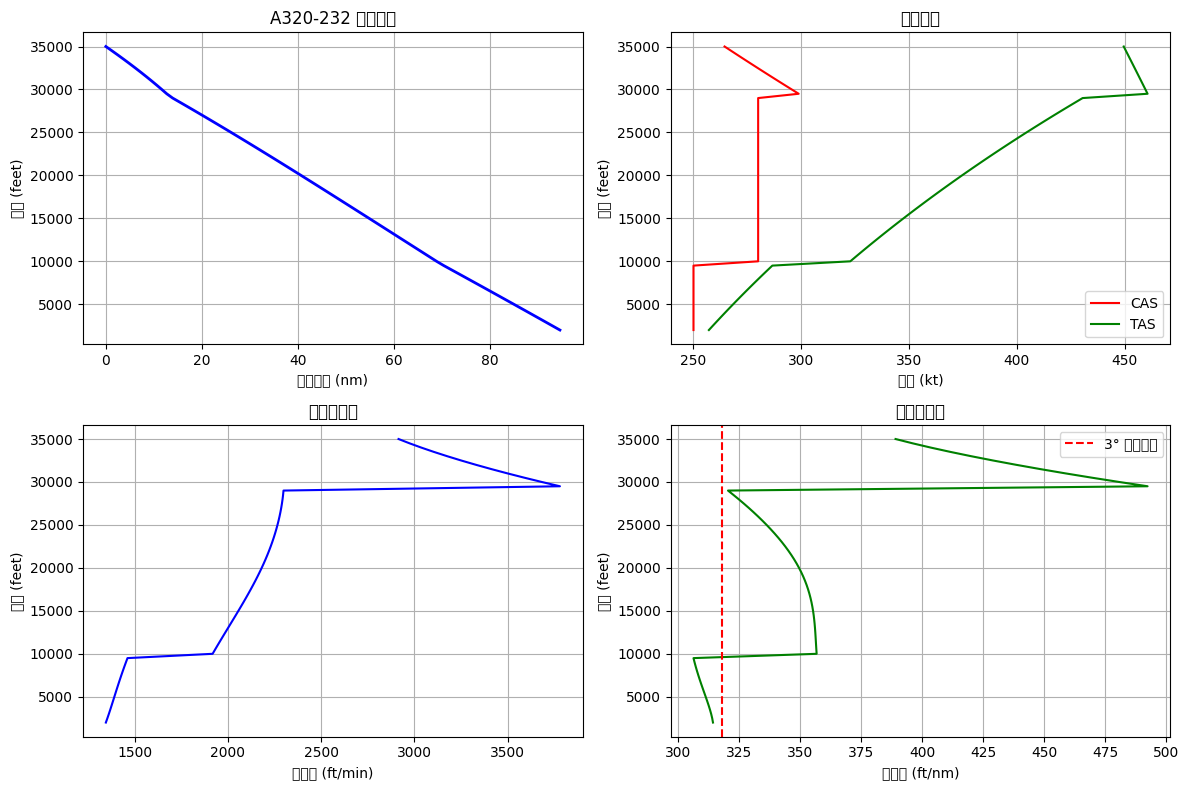

总下降距离: 94.5 海里
总高度变化: 33000 英尺
平均下降梯度: 5.74%


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假设results已经包含了您提供的所有数据
# 提取需要的列
flight_levels = [result["FL"] for result in results]
ft_per_nm = [result["高距离(ft/nm)"] for result in results]
cas_values = [result["CAS(kt)"] for result in results]
tas_values = [result["TAS(kt)"] for result in results]
descent_rates = [result["下降率(ft/min)"] for result in results]

# 计算每个高度层的高度(英尺)
altitudes_ft = [fl * 100 for fl in flight_levels]

# 计算水平距离(累积)
horizontal_distance = np.zeros(len(flight_levels))
for i in range(1, len(flight_levels)):
    # 计算相邻高度层之间的高度差(英尺)
    altitude_diff = (flight_levels[i-1] - flight_levels[i]) * 100
    # 使用高距离(ft/nm)计算水平距离(海里)
    # 使用两个点的平均高距离比
    avg_ft_per_nm = (ft_per_nm[i-1] + ft_per_nm[i]) / 2
    if avg_ft_per_nm > 0:
        segment_distance = altitude_diff / avg_ft_per_nm
    else:
        segment_distance = 0
    # 累积水平距离
    horizontal_distance[i] = horizontal_distance[i-1] + segment_distance

# 创建下降轨迹图
plt.figure(figsize=(12, 8))

# 绘制主轨迹图
plt.subplot(2, 2, 1)
plt.plot(horizontal_distance, altitudes_ft, 'b-', linewidth=2)
plt.xlabel('水平距离 (nm)')
plt.ylabel('高度 (feet)')
plt.title('A320-232 下降轨迹')
plt.grid(True)

# 速度vs高度
plt.subplot(2, 2, 2)
plt.plot(cas_values, altitudes_ft, 'r-', label='CAS')
plt.plot(tas_values, altitudes_ft, 'g-', label='TAS')
plt.xlabel('速度 (kt)')
plt.ylabel('高度 (feet)')
plt.title('速度剖面')
plt.legend()
plt.grid(True)

# 下降率vs高度
plt.subplot(2, 2, 3)
plt.plot([-rate for rate in descent_rates], altitudes_ft, 'b-')
plt.xlabel('下降率 (ft/min)')
plt.ylabel('高度 (feet)')
plt.title('下降率剖面')
plt.grid(True)

# 高距离vs高度
plt.subplot(2, 2, 4)
plt.plot(ft_per_nm, altitudes_ft, 'g-')
plt.xlabel('高距离 (ft/nm)')
plt.ylabel('高度 (feet)')
plt.title('高距离剖面')
plt.axvline(x=318, color='r', linestyle='--', label='3° 下降路径')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('A320_descent_profile.png', dpi=300)
plt.show()

# 打印下降总距离
print(f"总下降距离: {horizontal_distance[-1]:.1f} 海里")
print(f"总高度变化: {altitudes_ft[0] - altitudes_ft[-1]:.0f} 英尺")
print(f"平均下降梯度: {(altitudes_ft[0] - altitudes_ft[-1])/6076.12/horizontal_distance[-1]*100:.2f}%")

In [84]:
# 计算下降时间
descent_times = np.zeros(len(flight_levels))
total_time_seconds = 0  # 秒

for i in range(1, len(flight_levels)):
    # 计算高度差(英尺)
    altitude_diff = (flight_levels[i-1] - flight_levels[i]) * 100
    
    # 使用平均下降率(ft/min)，转换为ft/sec
    avg_descent_rate_per_sec = (abs(descent_rates[i-1]) + abs(descent_rates[i])) / (2 * 60)
    
    # 计算这一段的时间(秒)
    if avg_descent_rate_per_sec > 0:
        segment_time_seconds = altitude_diff / avg_descent_rate_per_sec
    else:
        segment_time_seconds = 0
    
    # 累积时间
    total_time_seconds += segment_time_seconds
    descent_times[i] = total_time_seconds

print(f"基于下降率计算的总下降时间: {total_time_seconds:.0f}秒")

# 基于地速的计算
ground_speed_times = np.zeros(len(flight_levels))
total_gs_time_seconds = 0  # 秒

for i in range(1, len(flight_levels)):
    # 获取这一段的水平距离
    segment_distance = horizontal_distance[i] - horizontal_distance[i-1]
    
    # 使用平均TAS(kt)，转换为每秒海里数
    avg_tas_per_sec = (tas_values[i-1] + tas_values[i]) / (2 * 3600)
    
    # 计算这一段的时间(秒)
    if avg_tas_per_sec > 0:
        segment_time_seconds = segment_distance / avg_tas_per_sec
    else:
        segment_time_seconds = 0
    
    # 累积时间
    total_gs_time_seconds += segment_time_seconds
    ground_speed_times[i] = total_gs_time_seconds

print(f"基于地速计算的总下降时间: {total_gs_time_seconds:.0f}秒")

基于下降率计算的总下降时间: 981秒
基于地速计算的总下降时间: 981秒


####

#

In [85]:
# 使用相同的A320-232和BADA4初始化
altitude_ft = 35000
altitude_m = conv.ft2m(altitude_ft)
mass = 58050  # 90% MLW

# 计算大气参数
theta_val, delta_val, sigma_val = atm.atmosphereProperties(altitude_m, 0)

# 计算最大升力系数(清洁构型)
HLid = 0.0  # 无襟翼
LG = "LGUP"  # 起落架收起
max_cl = bada4.CLmax(M=0.6, HLid=HLid, LG=LG)  # 使用参考马赫数

# 计算失速马赫数
# 公式: CL = (2*W)/(ρ*S*M²*a²)，求解M
S = AC.S  # 机翼面积
a = atm.aSound(theta_val)  # 声速
rho = sigma_val * 1.225  # 空气密度

# 从CL公式求解最小马赫数
min_mach = np.sqrt((2 * mass * 9.80665) / (rho * S * max_cl * a * a))

# 添加缓冲区(通常额外10-15%)
min_op_mach = min_mach * 1.12  

print(f"计算的最小飞行马赫数: {min_op_mach:.3f}")

计算的最小飞行马赫数: 0.607


In [88]:
# 计算马赫0.70与250节CAS的过渡高度
mach = 0.70
cas_250kt = 250
cas_250ms = conv.kt2ms(cas_250kt)  # 转换为m/s

# 使用crossOver函数计算过渡高度
crossover_250_m = atm.crossOver(cas=cas_250ms, Mach=mach)
crossover_250_ft = conv.m2ft(crossover_250_m)
crossover_250_fl = int(crossover_250_ft / 100)

print(f"马赫0.70/250节CAS的过渡高度: FL{crossover_250_fl} ({int(crossover_250_ft)} 英尺)")

马赫0.70/250节CAS的过渡高度: FL322 (32260 英尺)


In [ ]:
import pandas as pd
import numpy as np
import pyBADA.atmosphere as atm

# 自定义转换函数
class conv:
    @staticmethod
    def ft2m(feet):
        return feet * 0.3048
    
    @staticmethod
    def m2ft(meters):
        return meters / 0.3048
    
    @staticmethod
    def kt2ms(knots):
        return knots * 0.51444
    
    @staticmethod
    def ms2kt(ms):
        return ms / 0.51444

# 创建马赫数和CAS范围
mach_range = np.arange(0.70, 0.86, 0.01)
cas_range = np.arange(250, 351, 10)

# 创建结果矩阵
results = []

# 计算所有组合的过渡高度
for mach in mach_range:
    row = [mach]
    for cas in cas_range:
        cas_ms = conv.kt2ms(cas)
        try:
            crossover_m = atm.crossOver(cas=cas_ms, Mach=mach)
            crossover_ft = conv.m2ft(crossover_m)
            crossover_fl = int(crossover_ft / 100)
            row.append(crossover_fl)
        except:import pandas as pd
import numpy as np
import pyBADA.atmosphere as atm

# 自定义转换函数
class conv:
    @staticmethod
    def ft2m(feet):
        return feet * 0.3048
    
    @staticmethod
    def m2ft(meters):
        return meters / 0.3048
    
    @staticmethod
    def kt2ms(knots):
        return knots * 0.51444
    
    @staticmethod
    def ms2kt(ms):
        return ms / 0.51444

# 创建马赫数和CAS范围
mach_range = np.arange(0.70, 0.86, 0.01)
cas_range = np.arange(250, 351, 10)

# 创建结果矩阵
results = []

# 计算所有组合的过渡高度
for mach in mach_range:
    row = [mach]
    for cas in cas_range:
        cas_ms = conv.kt2ms(cas)
        try:
            crossover_m = atm.crossOver(cas=cas_ms, Mach=mach)
            crossover_ft = conv.m2ft(crossover_m)
            crossover_fl = int(crossover_ft / 100)
            row.append(crossover_fl)
        except:
            row.append(None)  # 处理可能的错误情况
    results.append(row)

# 创建列名
columns = ['Mach'] + [f'{cas}kt' for cas in cas_range]

# 创建DataFrame并显示结果
df = pd.DataFrame(results, columns=columns)
print(df.to_string(index=False))

# 可选: 保存为CSV文件
df.to_csv('crossover_altitudes.csv', index=False)
            row.append(None)  # 处理可能的错误情况
    results.append(row)

# 创建列名
columns = ['Mach'] + [f'{cas}kt' for cas in cas_range]

# 创建DataFrame并显示结果
df = pd.DataFrame(results, columns=columns)
print(df.to_string(index=False))

# 可选: 保存为CSV文件
df.to_csv('crossover_altitudes.csv', index=False)

 Mach  250kt  260kt  270kt  280kt  290kt  300kt  310kt  320kt  330kt  340kt  350kt
 0.70    322    304    287    270    254    237    221    205    190    174    159
 0.71    329    311    294    277    261    245    229    213    197    182    167
 0.72    336    318    301    284    268    252    236    220    205    190    175
 0.73    342    325    308    291    275    259    243    227    212    197    182
 0.74    349    331    315    298    282    266    250    235    219    204    190
 0.75    355    338    321    305    289    273    257    242    227    212    197
 0.76    361    344    328    311    295    279    264    249    234    219    204
 0.77    368    351    334    318    302    286    271    255    241    226    211
 0.78    374    357    340    324    308    293    277    262    247    233    218
 0.79    380    363    347    330    315    299    284    269    254    239    225
 0.80    386    369    353    337    321    305    290    275    261    246    232
 0.8

## FL350到FL020的下降剖面代码，使用新的速度剖面(.70/250/220节)：

In [90]:
from pyBADA.bada4 import Bada4Aircraft, BADA4
from pyBADA.aircraft import Airplane
import pyBADA.atmosphere as atm
import math
import pandas as pd
import numpy as np

# 自定义转换函数
class conv:
    @staticmethod
    def ft2m(feet):
        return feet * 0.3048
    
    @staticmethod
    def m2ft(meters):
        return meters / 0.3048
    
    @staticmethod
    def kt2ms(knots):
        return knots * 0.51444
    
    @staticmethod
    def ms2kt(ms):
        return ms / 0.51444

# 初始化A320-232飞机模型
AC = Bada4Aircraft(
    badaVersion="4.2",
    acName="A320-232",
    filePath="/home/longqin/Downloads/4.2/BADA_4.2_L06514UPC/Models",
)

# 创建BADA4性能计算对象
bada4 = BADA4(AC)

# 设置A320参数
max_landing_weight = 64500  # kg
aircraft_mass = int(max_landing_weight * 0.90)  # 90%最大着陆重量
print(f"飞机重量: {aircraft_mass} kg (MLW的90%)")

# 计算马赫0.70和250节CAS的过渡高度
mach = 0.70
cas_kt = 250
cas_ms = conv.kt2ms(cas_kt)
crossover_m = atm.crossOver(cas=cas_ms, Mach=mach)
crossover_ft = conv.m2ft(crossover_m)
crossover_fl = int(crossover_ft / 100)
print(f"过渡高度: FL{crossover_fl} ({int(crossover_ft)} 英尺)")

def calculate_descent_performance(flight_level, aircraft_mass, DeltaTemp=0):
    """计算指定飞行高度层的下降性能"""
    altitude_ft = flight_level * 100
    altitude_m = conv.ft2m(altitude_ft)
    
    # 计算大气参数
    theta_val, delta_val, sigma_val = atm.atmosphereProperties(altitude_m, DeltaTemp)
    
    # 根据下降速度规则确定速度
    if flight_level >= crossover_fl:
        # 使用马赫数0.70
        M = 0.70
        tas = atm.mach2Tas(M, theta_val)
        cas = atm.mach2Cas(M, theta_val, delta_val, sigma_val)
        speed_mode = "Mach 0.70"
        flight_evolution = "constM"
    elif flight_level >= 150:
        # 使用250节CAS
        cas = conv.kt2ms(250)
        tas = atm.cas2Tas(cas, delta_val, sigma_val)
        M = atm.tas2Mach(tas, theta_val)
        speed_mode = "CAS 250kt"
        flight_evolution = "constCAS"
    else:
        # 使用220节CAS
        cas = conv.kt2ms(220)
        tas = atm.cas2Tas(cas, delta_val, sigma_val)
        M = atm.tas2Mach(tas, theta_val)
        speed_mode = "CAS 220kt"
        flight_evolution = "constCAS"
    
    # 动态计算能量分配因子
    esf_des = Airplane.esf(
        h=altitude_m,
        DeltaTemp=DeltaTemp,
        flightEvolution=flight_evolution,
        phase="des",
        M=M
    )
    
    # 计算升力系数
    cl = bada4.CL(delta=delta_val, mass=aircraft_mass, M=M)
    
    # 计算阻力系数(干净构型)
    HLid = 0.0  # 无襟翼
    LG = "LGUP"  # 起落架收起
    cd = bada4.CD(HLid=HLid, LG=LG, CL=cl, M=M)
    
    # 计算阻力
    drag = bada4.D(delta=delta_val, M=M, CD=cd)
    
    # 计算怠速推力
    idle_thrust = bada4.Thrust(
        delta=delta_val,
        theta=theta_val,
        M=M,
        rating="LIDL",  # 怠速设置
        DeltaTemp=DeltaTemp
    )
    
    # 计算怠速下降率
    idle_descent_rate = bada4.ROCD(
        T=idle_thrust,
        D=drag,
        v=tas,
        mass=aircraft_mass,
        ESF=esf_des,
        h=altitude_m,
        DeltaTemp=DeltaTemp
    )
    
    # 计算下降角(度)
    if tas > 0:
        descent_angle = math.degrees(math.asin(idle_descent_rate / tas))
    else:
        descent_angle = 0
    
    # 计算下降梯度(百分比)
    descent_gradient = 100 * abs(idle_descent_rate / tas) if tas > 0 else 0
    
    # 计算高距离
    ft_per_nm = abs(idle_descent_rate * 196.85 / conv.ms2kt(tas) * 60) if conv.ms2kt(tas) > 0 else 0
    
    return {
        "FL": flight_level,
        "高度(ft)": altitude_ft,
        "速度模式": speed_mode,
        "马赫数": M,
        "CAS(kt)": conv.ms2kt(cas),
        "TAS(kt)": conv.ms2kt(tas),
        "下降率(ft/min)": idle_descent_rate * 196.85,
        "下降率(m/s)": idle_descent_rate,
        "下降角(度)": descent_angle,
        "下降梯度(%)": descent_gradient,
        "高距离(ft/nm)": ft_per_nm,
        "ESF": esf_des,
        "阻力(N)": drag,
        "怠速推力(N)": idle_thrust
    }

# 更密集的高度采样 - 每5个高度层一个点
flight_levels = []
for fl in range(350, 15, -5):
    flight_levels.append(fl)
if 20 not in flight_levels:
    flight_levels.append(20)

results = []
for fl in flight_levels:
    result = calculate_descent_performance(fl, aircraft_mass)
    results.append(result)

# 创建DataFrame展示结果
df = pd.DataFrame(results)

# 打印结果
print("\nA320-232 下降剖面 (.70M/250/220下降法则):")
print("=" * 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format
print(df[['FL', '速度模式', 'CAS(kt)', 'TAS(kt)', 'ESF', '下降率(ft/min)', '下降角(度)', '下降梯度(%)', '高距离(ft/nm)']])

# 计算水平距离(累积)
horizontal_distance = np.zeros(len(flight_levels))
for i in range(1, len(flight_levels)):
    # 计算相邻高度层之间的高度差(英尺)
    altitude_diff = (flight_levels[i-1] - flight_levels[i]) * 100
    # 使用两个点的平均高距离比
    avg_ft_per_nm = (df.iloc[i-1]['高距离(ft/nm)'] + df.iloc[i]['高距离(ft/nm)']) / 2
    if avg_ft_per_nm > 0:
        segment_distance = altitude_diff / avg_ft_per_nm
    else:
        segment_distance = 0
    # 累积水平距离
    horizontal_distance[i] = horizontal_distance[i-1] + segment_distance

# 计算下降时间
descent_times = np.zeros(len(flight_levels))
total_time_seconds = 0  # 秒

for i in range(1, len(flight_levels)):
    # 获取这一段的水平距离
    segment_distance = horizontal_distance[i] - horizontal_distance[i-1]
    
    # 使用平均TAS(kt)，转换为每秒海里数
    avg_tas_per_sec = (df.iloc[i-1]['TAS(kt)'] + df.iloc[i]['TAS(kt)']) / (2 * 3600)
    
    # 计算这一段的时间(秒)
    if avg_tas_per_sec > 0:
        segment_time_seconds = segment_distance / avg_tas_per_sec
    else:
        segment_time_seconds = 0
    
    # 累积时间
    total_time_seconds += segment_time_seconds
    descent_times[i] = total_time_seconds

# 打印总体结果
print(f"\n总下降距离: {horizontal_distance[-1]:.1f} 海里")
print(f"总高度变化: {33000:.0f} 英尺")
print(f"总下降时间: {total_time_seconds:.0f} 秒 ({total_time_seconds/60:.1f} 分钟)")
print(f"平均下降梯度: {33000/6076.12/horizontal_distance[-1]*100:.2f}%")

飞机重量: 58050 kg (MLW的90%)
过渡高度: FL322 (32260 英尺)

A320-232 下降剖面 (.70M/250/220下降法则):
     FL       速度模式  CAS(kt)  TAS(kt)  ESF  下降率(ft/min)  下降角(度)  下降梯度(%)  高距离(ft/nm)
0   350  Mach 0.70   234.90   403.50 1.07     -2291.89   -3.22     5.61      340.80
1   345  Mach 0.70   237.61   404.41 1.07     -2316.53   -3.24     5.66      343.69
2   340  Mach 0.70   240.35   405.32 1.07     -2344.80   -3.27     5.71      347.10
3   335  Mach 0.70   243.10   406.23 1.07     -2376.49   -3.31     5.78      351.01
4   330  Mach 0.70   245.87   407.13 1.07     -2411.42   -3.35     5.85      355.37
..  ...        ...      ...      ...  ...          ...     ...      ...         ...
62   40  CAS 220kt   220.00   232.96 0.93     -1130.38   -2.75     4.79      291.13
63   35  CAS 220kt   220.00   231.28 0.94     -1123.86   -2.75     4.80      291.55
64   30  CAS 220kt   220.00   229.62 0.94     -1116.62   -2.75     4.80      291.77
65   25  CAS 220kt   220.00   227.98 0.94     -1108.54   -2.75     4.80      

 ## FL350到FL020的下降剖面代码，使用马赫0.73过渡到250节CAS的速度剖面

In [91]:
from pyBADA.bada4 import Bada4Aircraft, BADA4
from pyBADA.aircraft import Airplane
import pyBADA.atmosphere as atm
import math
import pandas as pd
import numpy as np

# 自定义转换函数
class conv:
    @staticmethod
    def ft2m(feet):
        return feet * 0.3048
    
    @staticmethod
    def m2ft(meters):
        return meters / 0.3048
    
    @staticmethod
    def kt2ms(knots):
        return knots * 0.51444
    
    @staticmethod
    def ms2kt(ms):
        return ms / 0.51444

# 初始化A320-232飞机模型
AC = Bada4Aircraft(
    badaVersion="4.2",
    acName="A320-232",
    filePath="/home/longqin/Downloads/4.2/BADA_4.2_L06514UPC/Models",
)

# 创建BADA4性能计算对象
bada4 = BADA4(AC)

# 设置A320参数
max_landing_weight = 64500  # kg
aircraft_mass = int(max_landing_weight * 0.90)  # 90%最大着陆重量
print(f"飞机重量: {aircraft_mass} kg (MLW的90%)")

# 计算马赫0.73和250节CAS的过渡高度
mach = 0.73
cas_kt = 250
cas_ms = conv.kt2ms(cas_kt)
crossover_m = atm.crossOver(cas=cas_ms, Mach=mach)
crossover_ft = conv.m2ft(crossover_m)
crossover_fl = int(crossover_ft / 100)
print(f"过渡高度: FL{crossover_fl} ({int(crossover_ft)} 英尺)")

def calculate_descent_performance(flight_level, aircraft_mass, DeltaTemp=0):
    """计算指定飞行高度层的下降性能"""
    altitude_ft = flight_level * 100
    altitude_m = conv.ft2m(altitude_ft)
    
    # 计算大气参数
    theta_val, delta_val, sigma_val = atm.atmosphereProperties(altitude_m, DeltaTemp)
    
    # 根据下降速度规则确定速度
    if flight_level >= crossover_fl:
        # 使用马赫数0.73
        M = 0.73
        tas = atm.mach2Tas(M, theta_val)
        cas = atm.mach2Cas(M, theta_val, delta_val, sigma_val)
        speed_mode = "Mach 0.73"
        flight_evolution = "constM"
    else:
        # 使用250节CAS
        cas = conv.kt2ms(250)
        tas = atm.cas2Tas(cas, delta_val, sigma_val)
        M = atm.tas2Mach(tas, theta_val)
        speed_mode = "CAS 250kt"
        flight_evolution = "constCAS"
    
    # 动态计算能量分配因子
    esf_des = Airplane.esf(
        h=altitude_m,
        DeltaTemp=DeltaTemp,
        flightEvolution=flight_evolution,
        phase="des",
        M=M
    )
    
    # 计算升力系数
    cl = bada4.CL(delta=delta_val, mass=aircraft_mass, M=M)
    
    # 计算阻力系数(干净构型)
    HLid = 0.0  # 无襟翼
    LG = "LGUP"  # 起落架收起
    cd = bada4.CD(HLid=HLid, LG=LG, CL=cl, M=M)
    
    # 计算阻力
    drag = bada4.D(delta=delta_val, M=M, CD=cd)
    
    # 计算怠速推力
    idle_thrust = bada4.Thrust(
        delta=delta_val,
        theta=theta_val,
        M=M,
        rating="LIDL",  # 怠速设置
        DeltaTemp=DeltaTemp
    )
    
    # 计算怠速下降率
    idle_descent_rate = bada4.ROCD(
        T=idle_thrust,
        D=drag,
        v=tas,
        mass=aircraft_mass,
        ESF=esf_des,
        h=altitude_m,
        DeltaTemp=DeltaTemp
    )
    
    # 计算下降角(度)
    if tas > 0:
        descent_angle = math.degrees(math.asin(idle_descent_rate / tas))
    else:
        descent_angle = 0
    
    # 计算下降梯度(百分比)
    descent_gradient = 100 * abs(idle_descent_rate / tas) if tas > 0 else 0
    
    # 计算高距离
    ft_per_nm = abs(idle_descent_rate * 196.85 / conv.ms2kt(tas) * 60) if conv.ms2kt(tas) > 0 else 0
    
    return {
        "FL": flight_level,
        "高度(ft)": altitude_ft,
        "速度模式": speed_mode,
        "马赫数": M,
        "CAS(kt)": conv.ms2kt(cas),
        "TAS(kt)": conv.ms2kt(tas),
        "下降率(ft/min)": idle_descent_rate * 196.85,
        "下降率(m/s)": idle_descent_rate,
        "下降角(度)": descent_angle,
        "下降梯度(%)": descent_gradient,
        "高距离(ft/nm)": ft_per_nm,
        "ESF": esf_des,
        "阻力(N)": drag,
        "怠速推力(N)": idle_thrust
    }

# 更密集的高度采样 - 每5个高度层一个点
flight_levels = []
for fl in range(350, 15, -5):
    flight_levels.append(fl)
if 20 not in flight_levels:
    flight_levels.append(20)

results = []
for fl in flight_levels:
    result = calculate_descent_performance(fl, aircraft_mass)
    results.append(result)

# 创建DataFrame展示结果
df = pd.DataFrame(results)

# 打印结果
print("\nA320-232 下降剖面 (.73M/250下降法则):")
print("=" * 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format
print(df[['FL', '速度模式', 'CAS(kt)', 'TAS(kt)', 'ESF', '下降率(ft/min)', '下降角(度)', '下降梯度(%)', '高距离(ft/nm)']])

# 计算水平距离(累积)
horizontal_distance = np.zeros(len(flight_levels))
for i in range(1, len(flight_levels)):
    # 计算相邻高度层之间的高度差(英尺)
    altitude_diff = (flight_levels[i-1] - flight_levels[i]) * 100
    # 使用两个点的平均高距离比
    avg_ft_per_nm = (df.iloc[i-1]['高距离(ft/nm)'] + df.iloc[i]['高距离(ft/nm)']) / 2
    if avg_ft_per_nm > 0:
        segment_distance = altitude_diff / avg_ft_per_nm
    else:
        segment_distance = 0
    # 累积水平距离
    horizontal_distance[i] = horizontal_distance[i-1] + segment_distance

# 计算下降时间
descent_times = np.zeros(len(flight_levels))
total_time_seconds = 0  # 秒

for i in range(1, len(flight_levels)):
    # 获取这一段的水平距离
    segment_distance = horizontal_distance[i] - horizontal_distance[i-1]
    
    # 使用平均TAS(kt)，转换为每秒海里数
    avg_tas_per_sec = (df.iloc[i-1]['TAS(kt)'] + df.iloc[i]['TAS(kt)']) / (2 * 3600)
    
    # 计算这一段的时间(秒)
    if avg_tas_per_sec > 0:
        segment_time_seconds = segment_distance / avg_tas_per_sec
    else:
        segment_time_seconds = 0
    
    # 累积时间
    total_time_seconds += segment_time_seconds
    descent_times[i] = total_time_seconds

# 打印总体结果
print(f"\n总下降距离: {horizontal_distance[-1]:.1f} 海里")
print(f"总高度变化: {33000:.0f} 英尺")
print(f"总下降时间: {total_time_seconds:.0f} 秒 ({total_time_seconds/60:.1f} 分钟)")
print(f"平均下降梯度: {33000/6076.12/horizontal_distance[-1]*100:.2f}%")

飞机重量: 58050 kg (MLW的90%)
过渡高度: FL342 (34274 英尺)

A320-232 下降剖面 (.73M/250下降法则):
     FL       速度模式  CAS(kt)  TAS(kt)  ESF  下降率(ft/min)  下降角(度)  下降梯度(%)  高距离(ft/nm)
0   350  Mach 0.73   245.88   420.79 1.08     -2486.10   -3.34     5.83      354.49
1   345  Mach 0.73   248.71   421.74 1.08     -2522.67   -3.39     5.91      358.89
2   340  CAS 250kt   250.00   420.27 0.80     -1872.40   -2.52     4.40      267.31
3   335  CAS 250kt   250.00   416.84 0.80     -1868.99   -2.54     4.43      269.02
4   330  CAS 250kt   250.00   413.44 0.80     -1865.29   -2.55     4.46      270.70
..  ...        ...      ...      ...  ...          ...     ...      ...         ...
62   40  CAS 250kt   250.00   264.57 0.92     -1377.43   -2.95     5.14      312.38
63   35  CAS 250kt   250.00   262.69 0.92     -1370.04   -2.95     5.15      312.93
64   30  CAS 250kt   250.00   260.82 0.92     -1362.46   -2.96     5.16      313.42
65   25  CAS 250kt   250.00   258.97 0.92     -1354.62   -2.96     5.17      313.